In [1]:
# library imports
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from platform import python_version
print(python_version())

3.8.8


In [2]:
attacked_computers = ['SysClient0501.systemia.com','SysClient0201.systemia.com','SysClient0351.systemia.com','SysClient0811.systemia.com',
                      'SysClient0051.systemia.com','SysClient0660.systemia.com','SysClient0874.systemia.com','SysClient0104.systemia.com',
                      'SysClient0205.systemia.com','SysClient0321.systemia.com','SysClient0355.systemia.com',
                      'SysClient0974.systemia.com','SysClient0955.systemia.com','SysClient0462.systemia.com','SysClient0609.systemia.com',
                      'SysClient0255.systemia.com','SysClient0559.systemia.com','SysClient0402.systemia.com','SysClient0419.systemia.com',
                      'SysClient0170.systemia.com','SysClient0503.systemia.com','SysClient0771.systemia.com','SysClient0005.systemia.com',
                      'SysClient0010.systemia.com','SysClient0069.systemia.com','SysClient0203.systemia.com','SysClient0358.systemia.com',
                      'SysClient0618.systemia.com','SysClient0851.systemia.com'
                      ]

# various pandas settings
pd.set_option('max_columns', 5)
pd.set_option('display.width', 140)

### Ground Truth

Reproduce the figure from Benoit's paper - credit to them for doing over all dataset (I think)

In [3]:
# truth file - BUCKET same - file_name = "OpTCNCR/truth/labels.csv"

# Low side
datafile = "/Users/andrewveal/Downloads/labels.csv"
df_labels = pd.read_csv(datafile).drop_duplicates() 

print(df_labels.shape)
print(df_labels.iloc[0])

# df_labels[['object', 'action']].value_counts()

(292264, 7)
hostname               SysClient0201.systemia.com
id           43fb9623-3cd1-45ec-ab22-dbe46e75240e
objectID     96913629-c1c9-4503-9586-4a91de0e7311
actorID      af6b49d5-f648-41a4-946d-d92b174bae47
timestamp           2019-09-23T11:23:55.857-04:00
object                                    PROCESS
action                                     CREATE
Name: 0, dtype: object


In [4]:
df_labels[['objectID', 'actorID', 'object', 'action']].head(20)

,objectID,actorID,object,action
0,96913629-c1c9-4503-9586-4a91de0e7311,af6b49d5-f648-41a4-946d-d92b174bae47,PROCESS,CREATE
1,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,SHELL,COMMAND
2,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,SHELL,COMMAND
3,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,SHELL,COMMAND
4,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,SHELL,COMMAND
5,07d7e86a-cf6d-43bf-85ee-50dfddf186b4,96913629-c1c9-4503-9586-4a91de0e7311,FLOW,START
6,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,SHELL,COMMAND
7,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,SHELL,COMMAND
8,46381023-8bda-4eab-a41c-1728f1a1b69e,96913629-c1c9-4503-9586-4a91de0e7311,FLOW,MESSAGE
9,99c69966-a4f0-4abd-92c7-f2f5bd205350,96913629-c1c9-4503-9586-4a91de0e7311,FLOW,MESSAGE


In [5]:
def make_string(row, labs):
    tup = ""
    for lab in labs:
        tup = tup + row[lab] + "_"
    return tup

msk = df_labels['object'].isnull()
for row in df_labels.loc[msk].index :
    df_labels.at[row, 'object'] = 'UNKNOWN'

df_labels['object_action'] = df_labels.apply(make_string, axis=1, args=[['object', 'action']])

names_label = sorted(df_labels['object_action'].drop_duplicates().tolist())

for name in names_label:
    df_labels[name] = df_labels['object_action'].apply(lambda x: 1 if x == name else 0)

df_labels = df_labels.drop(['id','timestamp', 'object', 'action', 'object_action'],axis=1)

df_labels.iloc[0]

hostname                           SysClient0201.systemia.com
objectID                 96913629-c1c9-4503-9586-4a91de0e7311
actorID                  af6b49d5-f648-41a4-946d-d92b174bae47
FILE_CREATE_                                                0
FILE_DELETE_                                                0
FILE_MODIFY_                                                0
FILE_READ_                                                  0
FILE_RENAME_                                                0
FILE_WRITE_                                                 0
FLOW_MESSAGE_                                               0
FLOW_OPEN_                                                  0
FLOW_START_                                                 0
MODULE_LOAD_                                                0
PROCESS_CREATE_                                             1
PROCESS_OPEN_                                               0
PROCESS_TERMINATE_                                          0
REGISTRY

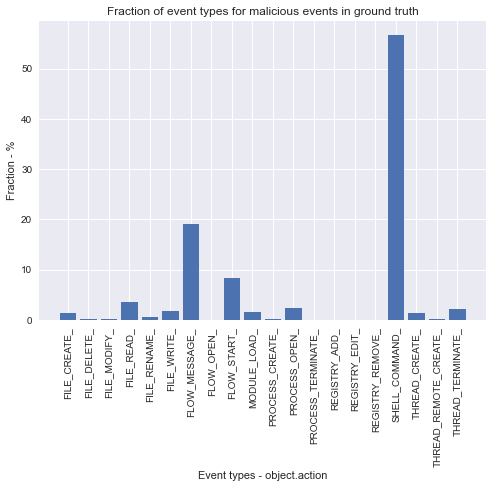

In [6]:
XL = df_labels.iloc[:, 3:]

frequenciesL = XL.sum(axis=0)

totalL = frequenciesL.sum()

fractionL = (frequenciesL * 100.0) / totalL

feature_listL = names_label

%matplotlib inline
# Set the style
plt.style.use('seaborn')
plt.tight_layout()
# list of x locations for plotting
x_values = list(range(len(fractionL)))
# Make a bar chart
plt.bar(x_values, fractionL, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_listL, rotation='vertical')
# Axis labels and title
plt.ylabel('Fraction - %'); plt.xlabel('Event types - object.action'); plt.title('Fraction of event types for malicious events in ground truth');

### code from Benoit

Idea - split data into day1, day2 and day3 - note: the 3 days do largely focus on different computers: unique to computer?

Recon phases - different 

day1, day2, day3 different attacks - do use different computers - different attack profiles

imbalanced learn - worth thinning out the majority benign processes - generic: not need too many to capture behaviour

side comment - what does a tsne plot look like?


labels = pd.read_csv("labels.csv", parse_dates=["timestamp"])
hosts_eval_day1 = set(labels.loc[labels["timestamp"].apply(lambda ts: ts.day) == 23]["hostname"])
hosts_eval_day23 = set(labels["hostname"]) - hosts_eval_day1
assert hosts_eval_day1 & hosts_eval_day23 == set()

Super helpful - can partition into day1 and day23 - different host sets


In [7]:
# Low side
datafile = "/Users/andrewveal/Downloads/labels.csv"
labels_df = pd.read_csv(datafile, parse_dates=["timestamp"]).drop_duplicates() 

print(labels_df.shape)
print(labels_df.iloc[0])

(292264, 7)
hostname               SysClient0201.systemia.com
id           43fb9623-3cd1-45ec-ab22-dbe46e75240e
objectID     96913629-c1c9-4503-9586-4a91de0e7311
actorID      af6b49d5-f648-41a4-946d-d92b174bae47
timestamp        2019-09-23 11:23:55.857000-04:00
object                                    PROCESS
action                                     CREATE
Name: 0, dtype: object


In [8]:
hosts_eval_day1 = set(labels_df.loc[labels_df["timestamp"].apply(lambda ts: ts.day) == 23]["hostname"])
hosts_eval_day23 = set(labels_df["hostname"]) - hosts_eval_day1
assert hosts_eval_day1 & hosts_eval_day23 == set()

In [9]:
hosts_eval_day1

{'SysClient0104.systemia.com',
 'SysClient0170.systemia.com',
 'SysClient0201.systemia.com',
 'SysClient0205.systemia.com',
 'SysClient0255.systemia.com',
 'SysClient0321.systemia.com',
 'SysClient0355.systemia.com',
 'SysClient0402.systemia.com',
 'SysClient0419.systemia.com',
 'SysClient0462.systemia.com',
 'SysClient0503.systemia.com',
 'SysClient0559.systemia.com',
 'SysClient0609.systemia.com',
 'SysClient0660.systemia.com',
 'SysClient0771.systemia.com',
 'SysClient0874.systemia.com',
 'SysClient0955.systemia.com'}

In [10]:
hosts_eval_day23

{'SysClient0010.systemia.com',
 'SysClient0051.systemia.com',
 'SysClient0069.systemia.com',
 'SysClient0203.systemia.com',
 'SysClient0351.systemia.com',
 'SysClient0358.systemia.com',
 'SysClient0501.systemia.com',
 'SysClient0618.systemia.com',
 'SysClient0811.systemia.com',
 'SysClient0851.systemia.com'}

In [11]:
hosts_eval_day2 = set(labels_df.loc[labels_df["timestamp"].apply(lambda ts: ts.day) == 24]["hostname"])
#hosts_eval_day23 = set(labels_df["hostname"]) - hosts_eval_day1
#assert hosts_eval_day1 & hosts_eval_day23 == set()

In [12]:
hosts_eval_day2

{'SysClient0010.systemia.com',
 'SysClient0069.systemia.com',
 'SysClient0203.systemia.com',
 'SysClient0358.systemia.com',
 'SysClient0501.systemia.com',
 'SysClient0618.systemia.com',
 'SysClient0811.systemia.com',
 'SysClient0851.systemia.com'}

In [13]:
hosts_eval_day3 = set(labels_df.loc[labels_df["timestamp"].apply(lambda ts: ts.day) == 25]["hostname"])

In [14]:
hosts_eval_day3

{'SysClient0010.systemia.com',
 'SysClient0051.systemia.com',
 'SysClient0069.systemia.com',
 'SysClient0203.systemia.com',
 'SysClient0351.systemia.com',
 'SysClient0358.systemia.com',
 'SysClient0501.systemia.com',
 'SysClient0618.systemia.com',
 'SysClient0851.systemia.com'}